### Autoencoders in Keras

In this tutorial, we look at Autoencoders from the perspective of Data Compression/Dimensionality Reduction. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

Using TensorFlow backend.


**Basic Autoencoder**

We'll first start with a simple autoencoder which has a one-layered Encoder network and a one-layered Decoder network. Both these layers are Dense layers.

We'll use the MNIST dataset for this purpose. To use the MNIST dataset on a Dense network, we need to unroll the image pixel-wise. Since the images are ```28 x 28```, these will be unrolled to ```784``` units in total.

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Unroll the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_train.shape, x_test.shape

((60000, 784), (10000, 784))

You'll notice we don't use the ```Sequential``` way to build models in this tutorial. We instead use the ```Model``` class. This is better when you have to make more customized models. This helps to make models with multiple submodels more easily.

In [4]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [5]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [6]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

To train the model, we simply put the input tensor in the place of ```y_train```.

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.3486 - val_loss: 0.2698
Epoch 2/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.2617 - val_loss: 0.2494
Epoch 3/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.2388 - val_loss: 0.2263
Epoch 4/50
60000/60000 [==============================] - 4s 75us/step - loss: 0.2190 - val_loss: 0.2092
Epoch 5/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.2043 - val_loss: 0.1968
Epoch 6/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.1937 - val_loss: 0.1878
Epoch 7/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.1854 - val_loss: 0.1804
Epoch 8/50
60000/60000 [==============================] - 5s 76us/step - loss: 0.1784 - val_loss: 0.1739
Epoch 9/50
60000/60000 [==============================] - 5s 7

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Let's visualize the outputs of the decoder model to get an idea of how this autoencoder did.

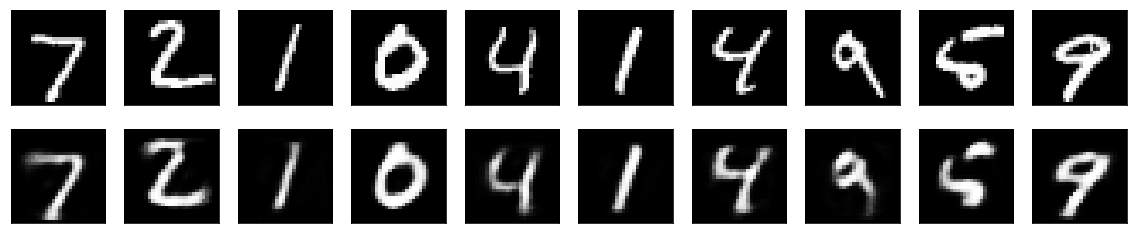

In [10]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

**Deep Convolutional Autoencoder**

Here we look at a more specialized autoencoder, one with Convolutional and Max Pooling layers instead of Dense layers and having more than one layer in the Encoder and Decoder networks.

This makes more sense of course because the MNIST dataset is an image dataset. Let's start with loading the dataset.

In [11]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

Create the model.

In [12]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 70s 1ms/step - loss: 0.2264 - val_loss: 0.1696
Epoch 2/5
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1609 - val_loss: 0.1483
Epoch 3/5
28160/60000 [=============>................] - ETA: 32s - loss: 0.1473

In [ ]:
autoencoder.summary()

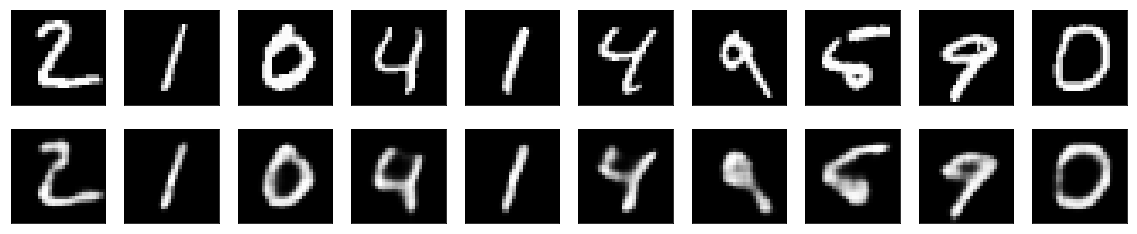

In [19]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()